# Context

This notebook aims at studying the learning and/or crafting of matrix $H$, the rhytmic patten matrix. The idea is to introduce prior knowledge on this matrix, in order to constraint the decomposition, and enhance interpretability. It could even enhance the decomposition for the task itself, but we can't be sure of that.

The idea is to, firstly, study this matrix on existing decomposition that I've stored. On this step, we notice that matrices seem globally close, which is not a surprise, as we've already noticed in previous experiments that $H$ matrices were of the same shape (a stair-like matrix).

As they seem close, we would like to find some methods to learn or define by hand an "optimal" or at least fixed $H$ matrix.

In this Notebook, we focus on the idea that we could fix $H$ in future computation, so we try to learn of crft this matrix.

When studying or using pre-computed NTD, we will use the ranks 12,16,20,24,28,32,36 for $H$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
import pandas as pd
import copy

import musicntd.data_manipulation as dm
import musicntd.tensor_factory as tf
import musicntd.autosimilarity_segmentation as as_seg
from musicntd.model.current_plot import *
import musicntd.scripts.overall_scripts as scr
import musicntd.scripts.final_tests as test
import musicntd.scripts.hide_code as hide
from nn_fac import ntd as NTD

annotations_folder_path = "C:\\Users\\amarmore\\Desktop\\Audio samples\\RWC Pop\\annotations"
persisted_path = "C:\\Users\\amarmore\\Desktop\\data_persisted"
dataset = "C:\\Users\\amarmore\\Desktop\\Audio samples\\RWC Pop\\Entire RWC"

annotations_type = "MIREX10"

annotations_folder = "{}\\{}".format(annotations_folder_path, annotations_type)
hop_length = 32
hop_length_seconds = 32/44100
subdivision = 96

convolution_type = "eight_bands"
penalty_func = "modulo8"
h_ranks = [12,16,20,24,28,32,36]

# Studying existing $H$ matrices

Firslty, looping on several ranks, we will vectorize each **permuted** $H$ matrix and compute autosimilarity of these vectors.

NB: **yes**, it's not perfect as permutation won't necessarily match the right columns, but it's the simplest approximation, which is good enough in my opinion to see that matrices are stair-like.

# Rank of $H$: 12

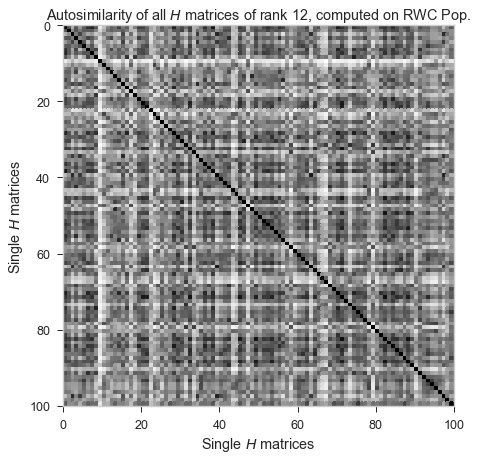

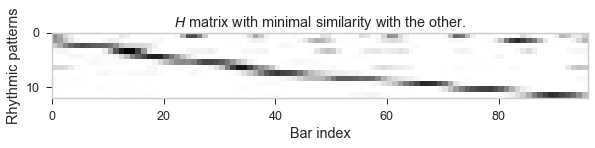

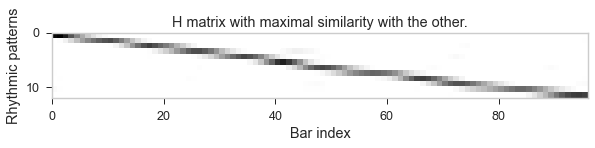

# Rank of $H$: 16

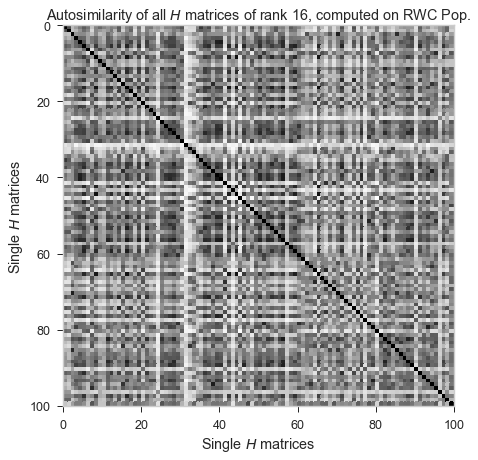

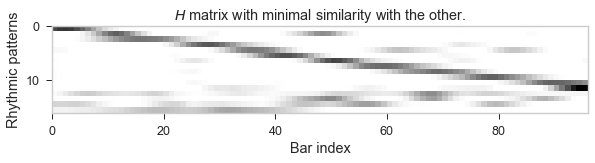

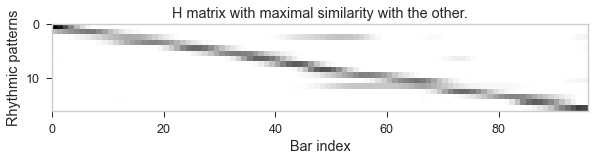

# Rank of $H$: 20

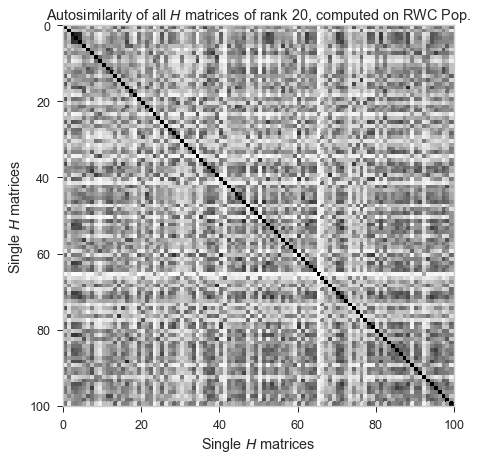

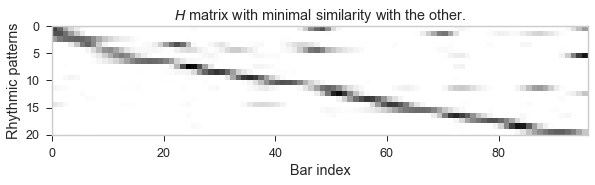

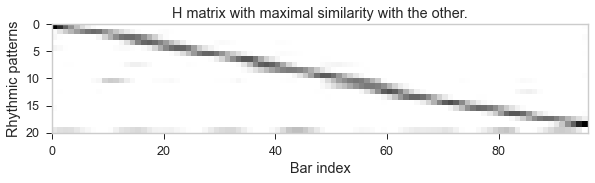

# Rank of $H$: 24

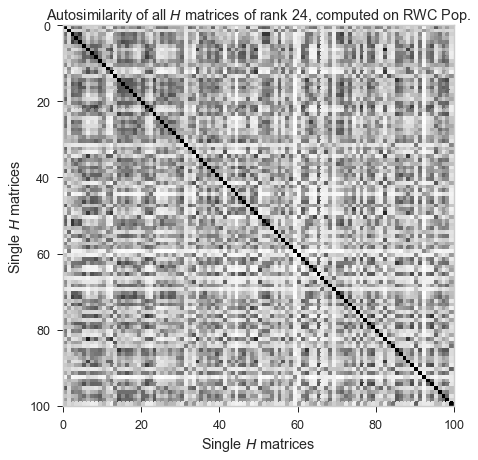

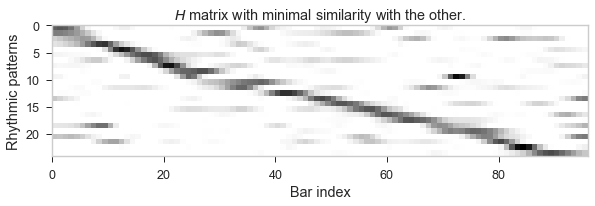

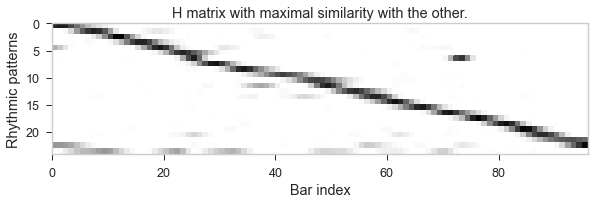

# Rank of $H$: 28

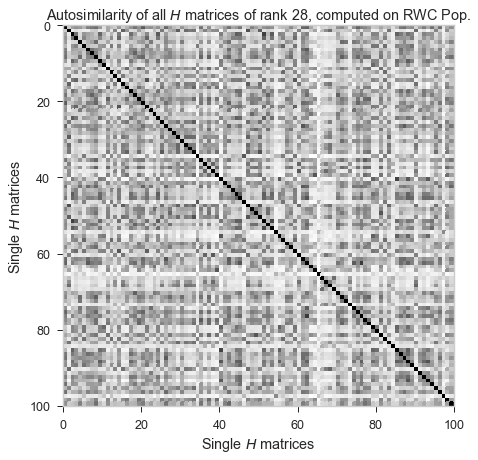

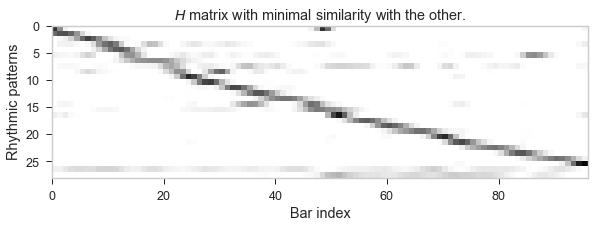

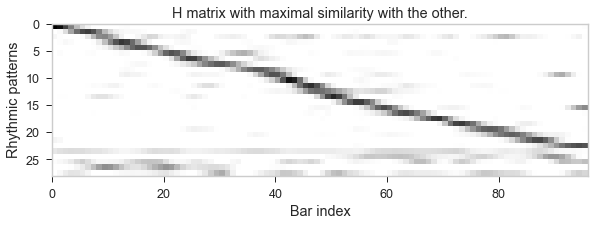

# Rank of $H$: 32

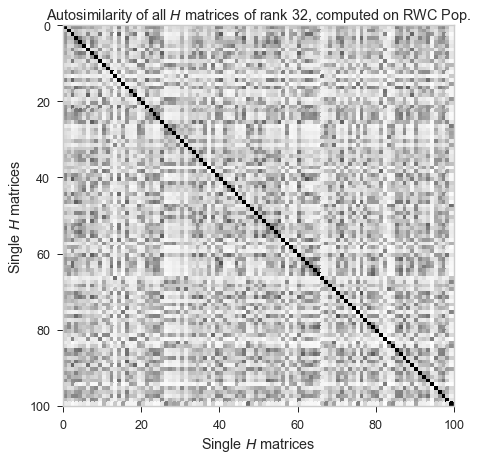

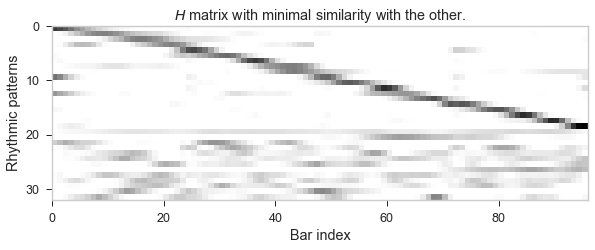

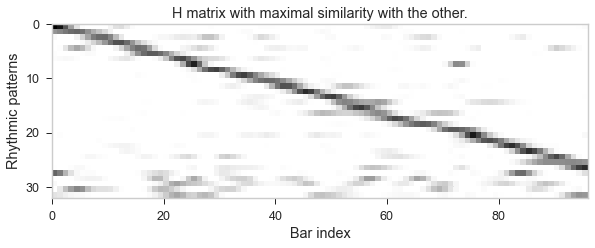

# Rank of $H$: 36

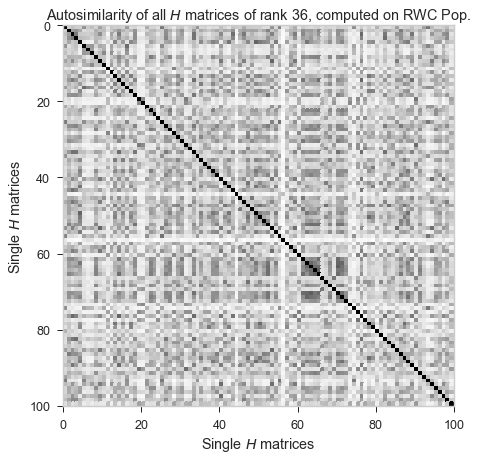

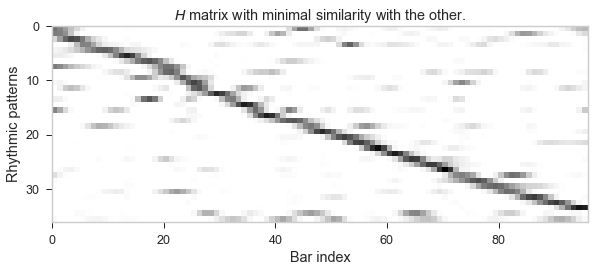

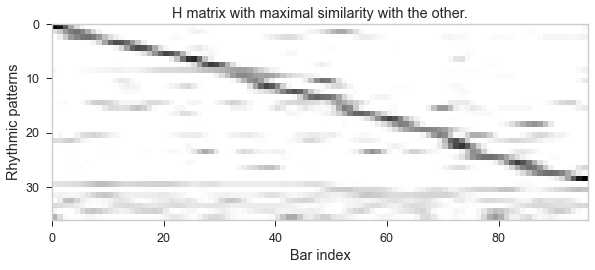

In [2]:
dataset_paths = scr.load_RWC_dataset(dataset, annotations_type)
for rank_h in h_ranks:
    hide.printmd("# Rank of $H$: {}".format(rank_h))
    all_h = []
    ranks = [12,rank_h,32]
    median_h = np.zeros((rank_h,96))
    for song_and_annotations in dataset_paths:
        #print('**Chanson courante: {}**'.format(song_and_annotations[0]))
        song_number = song_and_annotations[0].replace(".wav","")
        #annot_path = "{}\\{}".format(annotations_folder, song_and_annotations[1])
        #annotations = dm.get_segmentation_from_txt(annot_path, annotations_type)
        #references_segments = np.array(annotations)[:, 0:2]

        bars, spectrogram = scr.load_or_save_spectrogram_and_bars(persisted_path, "{}\\{}.wav".format(dataset, song_number), "pcp", hop_length)

        tensor_spectrogram = tf.tensorize_barwise(spectrogram, bars, hop_length_seconds, subdivision)

        persisted_arguments = "_{}_{}_{}_{}".format(song_number, "pcp", "chromas", subdivision)
        core, factors = scr.NTD_decomp_as_script(persisted_path, persisted_arguments, tensor_spectrogram, ranks, init = "chromas")

        h = permutate_factor(factors[1])
        #median_h += factors[1].T[h]
        all_h.append(np.reshape(factors[1].T[h], (subdivision*rank_h)))

    auto_seg_h = as_seg.get_autosimilarity(all_h, transpose = True)
    plot_me_this_spectrogram(auto_seg_h, title = "Autosimilarity of all $H$ matrices of rank {}, computed on RWC Pop.".format(rank_h), x_axis = "Single $H$ matrices", y_axis = "Single $H$ matrices")
    
    moy = [np.mean(auto_seg_h[i]) for i in range(100)]
    
    worst_song_for_h = dataset_paths[np.argmin(moy)][0].replace(".wav","")
    persisted_arguments_worst = "_{}_{}_{}_{}".format(worst_song_for_h, "pcp", "chromas", subdivision)
    core, worst_factors = scr.NTD_decomp_as_script(persisted_path, persisted_arguments_worst, tensor_spectrogram, ranks, init = "chromas")  
    plot_permuted_factor(worst_factors[1], title = "$H$ matrix with minimal similarity with the other.", x_axis = "Bar index", y_axis = "Rhythmic patterns")

    best_song_for_h = dataset_paths[np.argmax(moy)][0].replace(".wav","")
    persisted_arguments_best = "_{}_{}_{}_{}".format(best_song_for_h, "pcp", "chromas", subdivision)
    core, best_factors = scr.NTD_decomp_as_script(persisted_path, persisted_arguments_best, tensor_spectrogram, ranks, init = "chromas")  
    plot_permuted_factor(best_factors[1], title = "H matrix with maximal similarity with the other.", x_axis = "Bar index", y_axis = "Rhythmic patterns")

    #plot_me_this_spectrogram(median_h, title = "H moyen pour toutes les chansons")

As expected, all matrices seem stairish, even when their similarity is low with the other.

We see that, the larger the rank, the less similar the matrices are. I interpret that as "overfitting" the specific rhythm of the song, as it also result in shortest columns, and very blurry residuals.

A priori, the optimal rank shouldn't be too large to prevent this overfitting, which will also limit computation time.

# Averaging the $H$ matrix, columnwise.

For each of the precedent ranks, we will compute the average $H$ matrix, where columns are associated by their indexes in the permutation matrix.

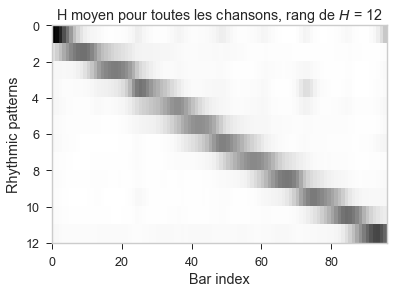

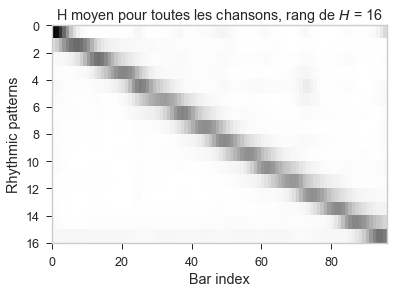

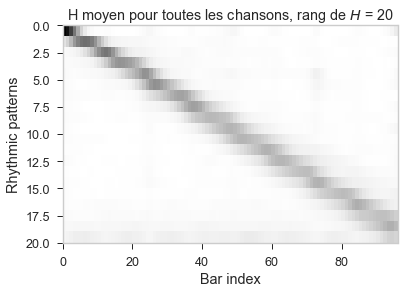

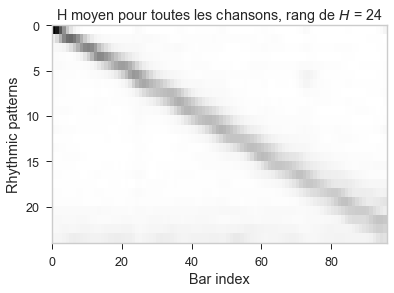

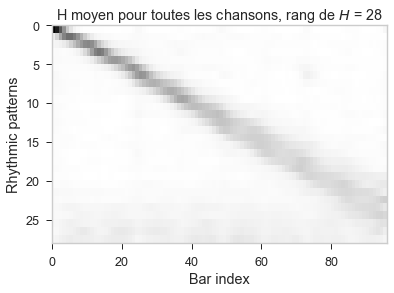

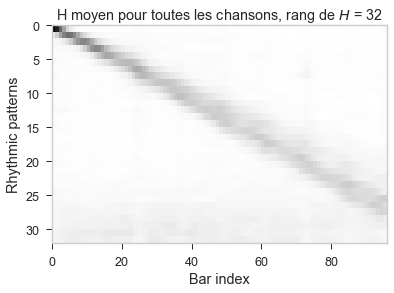

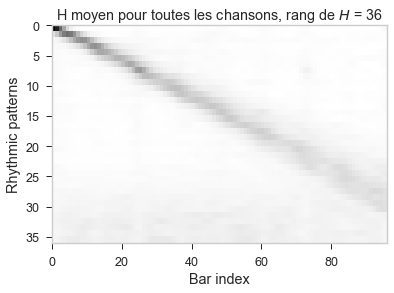

In [3]:
dataset_paths = scr.load_RWC_dataset(dataset, annotations_type)
for rank_h in h_ranks:
    all_h = []
    ranks = [12,rank_h,32]
    median_h = np.zeros((rank_h,96))
    for song_and_annotations in dataset_paths:
        song_number = song_and_annotations[0].replace(".wav","")
        bars, spectrogram = scr.load_or_save_spectrogram_and_bars(persisted_path, "{}\\{}".format(dataset, song_number), "pcp", hop_length)
        tensor_spectrogram = tf.tensorize_barwise(spectrogram, bars, hop_length_seconds, subdivision)
        persisted_arguments = "_{}_{}_{}_{}".format(song_number, "pcp", "chromas", subdivision)
        core, factors = scr.NTD_decomp_as_script(persisted_path, persisted_arguments, tensor_spectrogram, ranks, init = "chromas")

        h = permutate_factor(factors[1])
        median_h += factors[1].T[h]

    plot_me_this_spectrogram(median_h, title = "H moyen pour toutes les chansons, rang de $H$ = {}".format(rank_h), x_axis = "Bar index", y_axis = "Rhythmic patterns")

This technique is really limited by the permutation of columns, and is not really satisfactory.

It seems to lightly confirm the previous conclusions though, that the larger the rank and the more specific columns are, and the more "blurry columns " we have (the number of non-stairish columns at the end).

# Clustering columns of $H$.

A less permutation and column-dependant method is the clustering of all the columns of $H$.

Indeed, clustering all columns will gather the closest, independently of their order.

We will use the classic kmeans algorithm, implemented by scikit-learn for these tests.

In [4]:
import sklearn

## Clustering for *each* rank

Firstly, we will loop on every rank, and concatenate all columns of the different $H$ for the different songs for each individual rank.

In that sense, we perform the clustering on a matrix containing $rank * 100$ columns (100 correspond to all songs of RWC Pop).

For this task, the number of clusters will be set to $rank$ and $\frac{rank}{2}$.

# Rank of $H$: 12

For rank 12, centroids of the clusters formed by columns of all $H$ matrices.


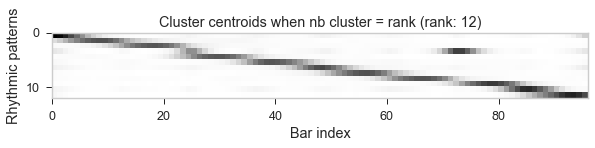

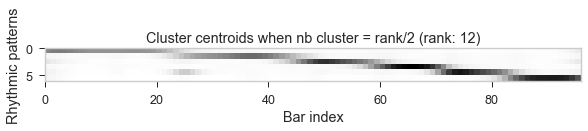

# Rank of $H$: 16

For rank 16, centroids of the clusters formed by columns of all $H$ matrices.


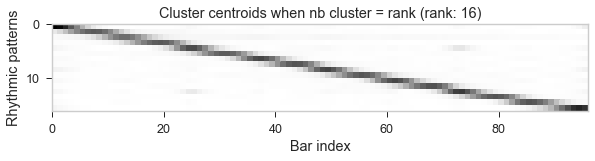

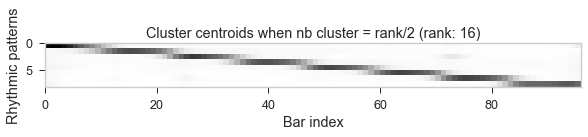

# Rank of $H$: 20

For rank 20, centroids of the clusters formed by columns of all $H$ matrices.


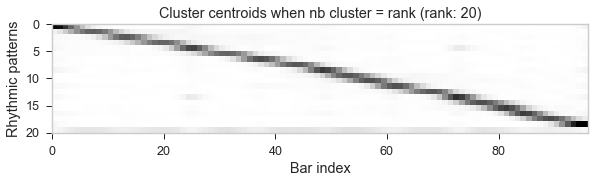

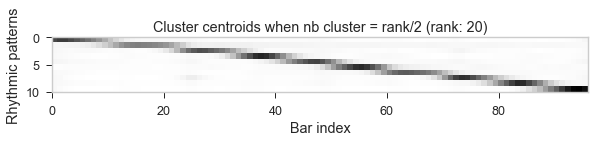

# Rank of $H$: 24

For rank 24, centroids of the clusters formed by columns of all $H$ matrices.


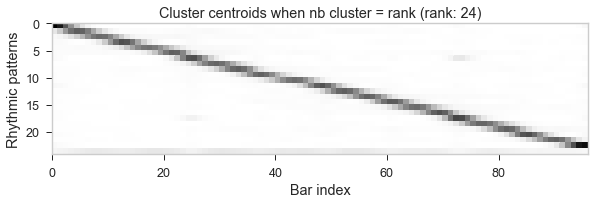

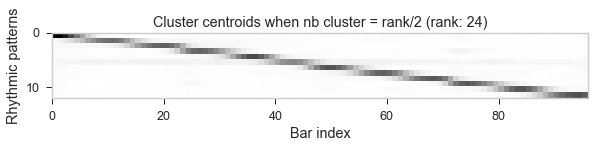

# Rank of $H$: 28

For rank 28, centroids of the clusters formed by columns of all $H$ matrices.


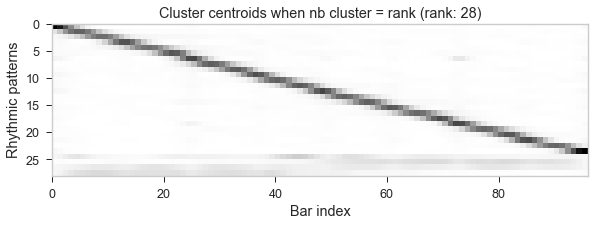

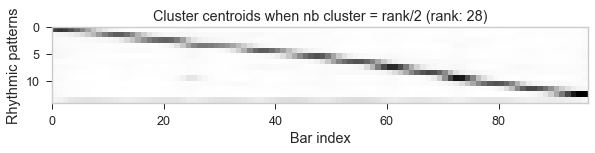

# Rank of $H$: 32

For rank 32, centroids of the clusters formed by columns of all $H$ matrices.


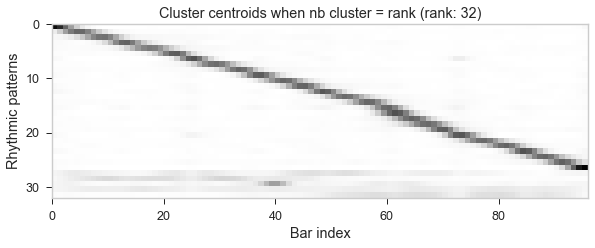

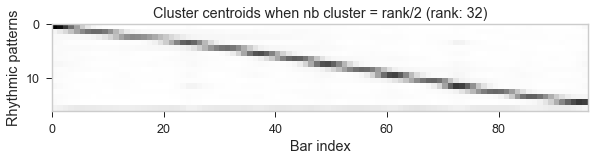

# Rank of $H$: 36

For rank 36, centroids of the clusters formed by columns of all $H$ matrices.


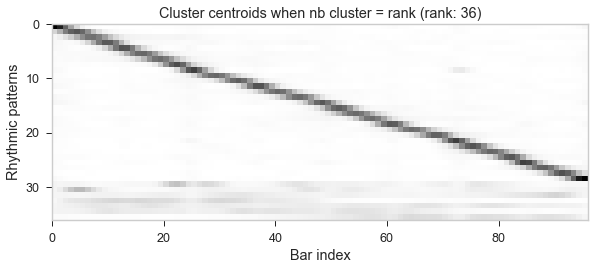

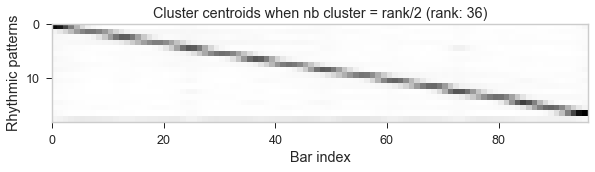

In [5]:
dataset_paths = scr.load_RWC_dataset(dataset, annotations_type)
for rank_h in h_ranks:
    hide.printmd("# Rank of $H$: {}".format(rank_h))
    all_h = []
    ranks = [12,rank_h,32]
    median_h = np.zeros((rank_h,96))
    for song_and_annotations in dataset_paths:
        song_number = song_and_annotations[0].replace(".wav","")
        annot_path = "{}\\{}".format(annotations_folder, song_and_annotations[1])
        annotations = dm.get_segmentation_from_txt(annot_path, annotations_type)
        references_segments = np.array(annotations)[:, 0:2]

        bars, spectrogram = scr.load_or_save_spectrogram_and_bars(persisted_path, "{}\\{}".format(dataset, song_number), "pcp", hop_length)

        tensor_spectrogram = tf.tensorize_barwise(spectrogram, bars, hop_length_seconds, subdivision)

        persisted_arguments = "_{}_{}_{}_{}".format(song_number, "pcp", "chromas", subdivision)
        core, factors = scr.NTD_decomp_as_script(persisted_path, persisted_arguments, tensor_spectrogram, ranks, init = "chromas")
        for column_h in factors[1].T:
            all_h.append(column_h)
    
    print("For rank {}, centroids of the clusters formed by columns of all $H$ matrices.".format(rank_h))
    kmeans = sklearn.cluster.KMeans(n_clusters = rank_h).fit(all_h)
    k_means_cluster_centers = kmeans.cluster_centers_
    plot_permuted_factor(k_means_cluster_centers.T, title = "Cluster centroids when nb cluster = rank (rank: {})".format(rank_h), x_axis = "Bar index", y_axis = "Rhythmic patterns")
    
    kmeans = sklearn.cluster.KMeans(n_clusters = int(rank_h/2)).fit(all_h)
    k_means_cluster_centers = kmeans.cluster_centers_
    plot_permuted_factor(k_means_cluster_centers.T, title = "Cluster centroids when nb cluster = rank/2 (rank: {})".format(rank_h), x_axis = "Bar index", y_axis = "Rhythmic patterns")

## Clustering **all** columns of all $H$ for different ranks.

Now, we will concatenate all the columns of all the $H$ matrices of different ranks, and we cluster all these columns with different number of clusters.

We hence cluster a unique $H$ matrix, containing $100 * 12*16*...*36$ columns (all columns of every evaluated decomposition).

We will cluster this matrix with different number of centroids, tu study its behavior. Centroids will be equal to 4,8,12,16,20,24,40.

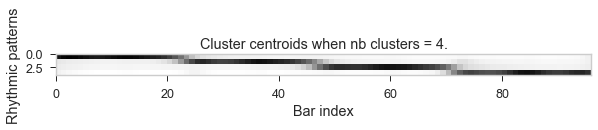

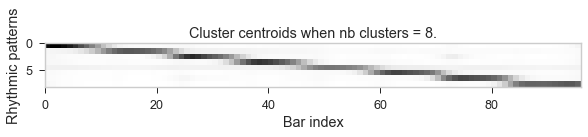

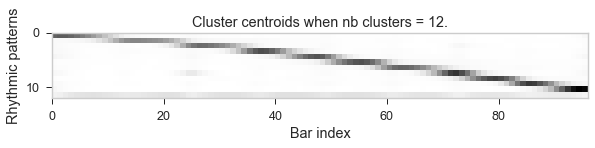

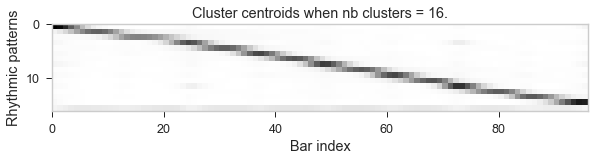

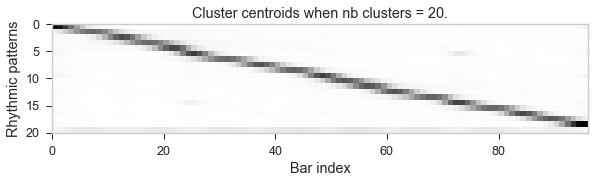

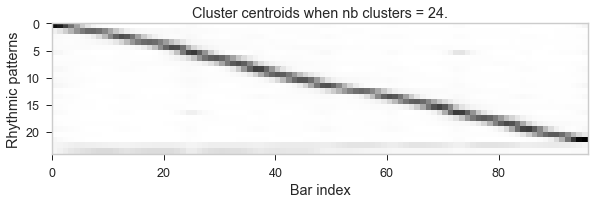

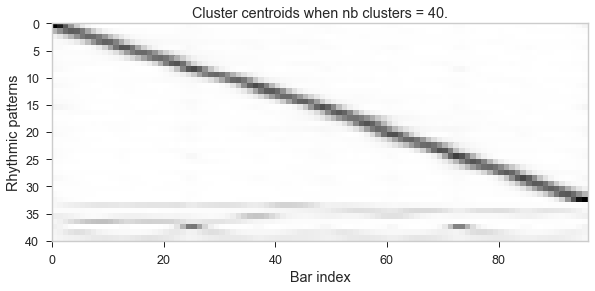

In [6]:
dataset_paths = scr.load_RWC_dataset(dataset, annotations_type)
all_h = []
for rank_h in h_ranks:
    ranks = [12,rank_h,32]
    median_h = np.zeros((rank_h,96))
    for song_and_annotations in dataset_paths:
        song_number = song_and_annotations[0].replace(".wav","")
        annot_path = "{}\\{}".format(annotations_folder, song_and_annotations[1])
        annotations = dm.get_segmentation_from_txt(annot_path, annotations_type)
        references_segments = np.array(annotations)[:, 0:2]

        bars, spectrogram = scr.load_or_save_spectrogram_and_bars(persisted_path, "{}\\{}".format(dataset, song_number), "pcp", hop_length)

        tensor_spectrogram = tf.tensorize_barwise(spectrogram, bars, hop_length_seconds, subdivision)

        persisted_arguments = "_{}_{}_{}_{}".format(song_number, "pcp", "chromas", subdivision)
        core, factors = scr.NTD_decomp_as_script(persisted_path, persisted_arguments, tensor_spectrogram, ranks, init = "chromas")
        for column_h in factors[1].T:
            all_h.append(column_h)

for n_clus in [4,8,12,16,20,24,40]:
    kmeans = sklearn.cluster.KMeans(n_clusters = n_clus).fit(all_h)
    k_means_cluster_centers = kmeans.cluster_centers_
    plot_permuted_factor(k_means_cluster_centers.T, title = "Cluster centroids when nb clusters = {}.".format(n_clus), x_axis = "Bar index", y_axis = "Rhythmic patterns")

# Creating H matrix

Finally, another option would be to create from scratch a $H$ matrix.

For this sake, having computed all previous centroids, we implement a $H$ matrix looking as gaussian distribution on each column, spanning all possible time position in the bar.

In [7]:
import scipy

In [8]:
def build_H(size_gauss, gaussian_std):
    size = int(subdivision/size_gauss)
    tab = np.array(np.zeros((2*size + 2,subdivision)))
    for i in range(size):
        reste = int(round(subdivision-size_gauss*(i+1)))
        if reste >= 0:
            to_add = np.concatenate((np.zeros((size_gauss*i)),scipy.signal.windows.gaussian(size_gauss, gaussian_std, sym=True),np.zeros((reste))))
        else:
            to_add = np.concatenate((scipy.signal.windows.gaussian(size_gauss, gaussian_std, sym=True)[size_gauss + reste:],np.zeros((subdivision - size_gauss)),scipy.signal.windows.gaussian(size_gauss, gaussian_std, sym=True)[:abs(reste)]))
        tab[2*i] = to_add

        reste = int(round(subdivision-size_gauss*(i+3/2)))
        if reste >= 0:
            to_add = np.concatenate((np.zeros((int(size_gauss*(i + 1/2)))),scipy.signal.windows.gaussian(size_gauss, gaussian_std, sym=True),np.zeros((reste))))
        else:
            to_add = np.concatenate((scipy.signal.windows.gaussian(size_gauss, gaussian_std, sym=True)[size_gauss + reste:],np.zeros((subdivision - size_gauss)),scipy.signal.windows.gaussian(size_gauss, gaussian_std, sym=True)[:abs(reste)]))
        tab[2*i + 1] = to_add

    line_croche = np.array([])
    for i in range(4): # on times
        line_croche = np.append(line_croche, np.concatenate((scipy.signal.windows.gaussian(size_gauss/1, gaussian_std, sym=True),np.zeros((int(subdivision/4 - size_gauss/1))))))
    tab[2*size] = line_croche

    line_counter_croche = np.array([])
    for i in range(8): # on times and counter-times
        line_counter_croche = np.append(line_counter_croche, np.concatenate((scipy.signal.windows.gaussian(size_gauss/1, gaussian_std, sym=True),np.zeros((int(subdivision/8 - size_gauss/1))))))
    tab[2*size + 1] = line_counter_croche
    return tab

In order to construct a $H$ matrix, we have to specify the size of each gaussian distribution, and its standard deviation (*how much* values and *how are they close* to each other).

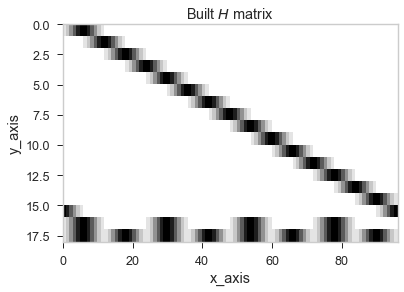

In [9]:
H_0 = build_H(12,3)
plot_me_this_spectrogram(H_0, title = "Built $H$ matrix")

In order to evaluate this matrix, we will compare a classic NTD (when everything is optimized) with a NTD with our built $H$ matrix.

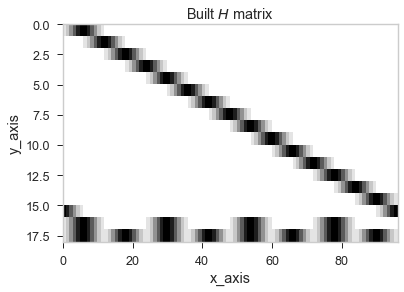

Irrelevant number of sparsity coefficient (different from the number of modes + 1 for the core), they have been set to None.


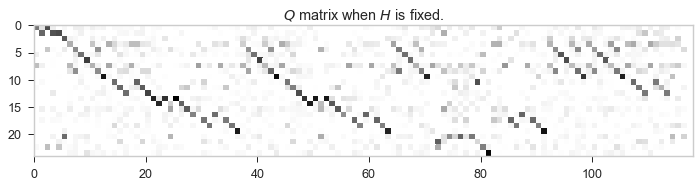

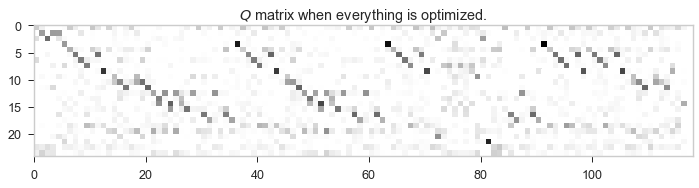

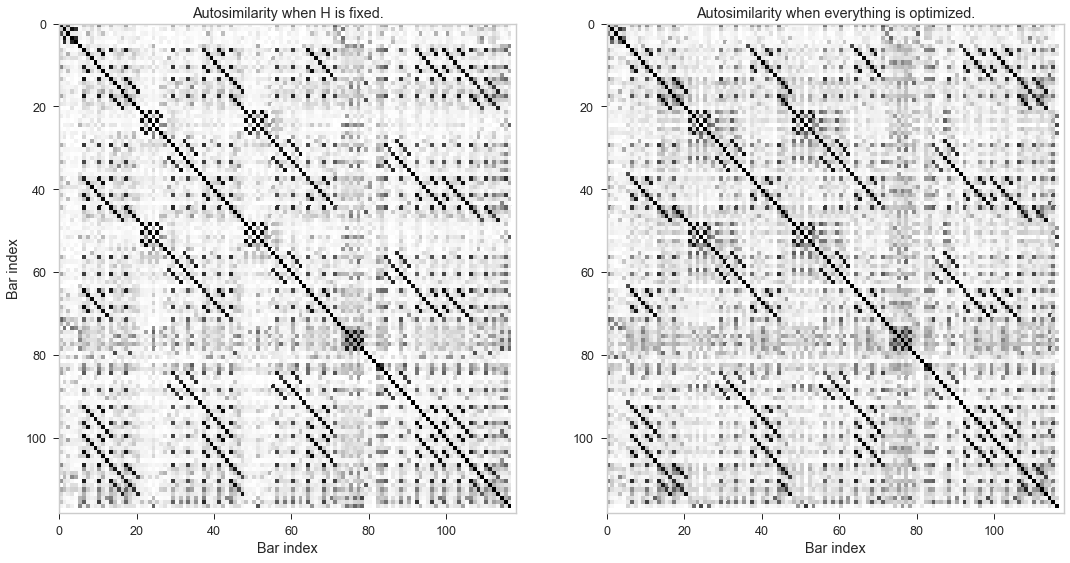

In [12]:
def study_impact_column_axel_without_permutation(fac, core, factor_number, columns, transpose = False, plotting = False, norm = 1):
    permutated_factor = fac[factor_number]
    cropped_factors = copy.deepcopy(fac)
    cropped_factors[factor_number] = np.zeros_like(fac[factor_number])
    if transpose:
        cropped_factors[factor_number][columns] = permutated_factor[columns]
    else:
        cropped_factors[factor_number][:,columns] = permutated_factor[:,columns]
    if plotting:
        plot_me_this_spectrogram(cropped_factors[factor_number])
    return tl.norm(tl.tenalg.multi_mode_dot(core, cropped_factors, transpose = False), 1) / tl.norm(tl.tenalg.multi_mode_dot(core, fac, transpose = False), 1)

H_0 = build_H(12,3)
rank_Q = 24
plot_me_this_spectrogram(H_0, title = "Built $H$ matrix")
dataset_paths = scr.load_RWC_dataset(dataset, annotations_type)
#for song_and_annotations in dataset_paths:
song_and_annotations = dataset_paths[0]
song_number = song_and_annotations[0].replace(".wav","")
annot_path = "{}\\{}".format(annotations_folder, song_and_annotations[1])
annotations = dm.get_segmentation_from_txt(annot_path, annotations_type)
references_segments = np.array(annotations)[:, 0:2]

bars, spectrogram = scr.load_or_save_spectrogram_and_bars(persisted_path, "{}\\{}".format(dataset, song_number), "pcp", hop_length)

tfb_tensor =  tf.tensorize_barwise(spectrogram, bars, hop_length_seconds, subdivision)
ranks = [12,H_0.shape[0],rank_Q]
core, factors = NTD.ntd(tfb_tensor, ranks, init='custom', core_0=np.random.random(tuple(ranks)), factors_0=[np.identity(12), H_0.T, np.random.random((tfb_tensor.shape[2], ranks[2]))], n_iter_max=100, tol=1e-06, sparsity_coefficients=[], fixed_modes=[0,1], normalize=[False, False, False, True], mode_core_norm=2, hals=False, verbose=False, return_errors=False, deterministic=False)

#for i in range(H_0.shape[0]):
#    print("Poids ligne {}: {}".format(i, study_impact_column_axel_without_permutation(factors, core, 1, [i], transpose = False, plotting = False, norm = 1)))

annotations_frontiers_barwise = dm.frontiers_from_time_to_bar(references_segments[:,1], bars)
autosimilarity = as_seg.get_autosimilarity(factors[2], transpose = True, normalize = True)
plot_permuted_factor(factors[2], title = "$Q$ matrix when $H$ is fixed.")

persisted_arguments = "_{}_{}_{}_{}".format(song_number, "pcp", "chromas", subdivision)
classic_core, classic_factors = scr.NTD_decomp_as_script(persisted_path, persisted_arguments, tfb_tensor, [12,32,rank_Q], init = "chromas")
classic_autosimilarity = as_seg.get_autosimilarity(classic_factors[2], transpose = True, normalize = True)
plot_permuted_factor(classic_factors[2], title = "$Q$ matrix when everything is optimized.")

fig, axs = plt.subplots(1, 2, figsize=(18,9))
padded_autosim_sign = pad_factor(autosimilarity)
padded_autosim_q = pad_factor(classic_autosimilarity)

axs[0].set_ylabel("Bar index")
axs[0].pcolormesh(np.arange(padded_autosim_sign.shape[0]), np.arange(padded_autosim_sign.shape[0]), padded_autosim_sign, cmap = cm.Greys)
axs[0].set_title('Autosimilarity when H is fixed.')
axs[1].pcolormesh(np.arange(padded_autosim_q.shape[0]), np.arange(padded_autosim_q.shape[0]), padded_autosim_q, cmap = cm.Greys)
axs[1].set_title('Autosimilarity when everything is optimized.')
for i in range(0,2):
    axs[i].set_xlabel("Bar index")
    axs[i].invert_yaxis()
plt.show()


Even if we can't conclude on an example, it looks like we don't lose a lot in quality by using our built matrix. It's a first, and a bit promising step.